In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/11.1.0'

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import haiku as hk
import jax
import optax
import jax.numpy as jnp
import numpy as onp
import pickle
from functools import partial

import tensorflow as tf
import tensorflow_datasets as tfds

from jax_lensing.inversion import ks93inv, ks93

from jax_lensing.spectral import measure_power_spectrum, make_power_map

from astropy.io import fits

from tqdm.notebook import tqdm

In [4]:
resolution = 0.29
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel
map_size = 360
gaussian_path = "../../data/ktng/ktng_PS_theory.npy"
sigma_gamma = .148

ps_data = onp.load(gaussian_path).astype('float32')
ell = jnp.array(ps_data[0,:])
ps_halofit = jnp.array(ps_data[1,:] / pixel_size**2) # normalisation by pixel size
kell = ell /2/jnp.pi * 360 * pixel_size / map_size
# Interpolate the Power Spectrum in Fourier Space
ps_map = jnp.array(make_power_map(ps_halofit, map_size, kps=kell))

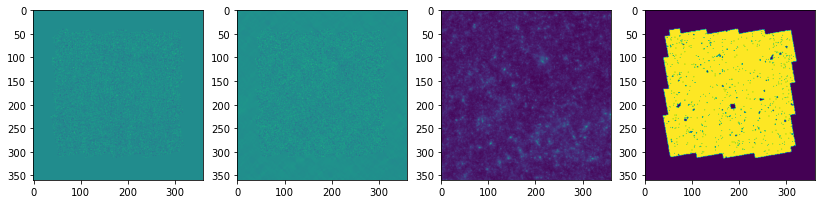

In [5]:
mask = fits.getdata('../../data/COSMOS/cosmos_full_mask_0.29arcmin360copy.fits').astype('float32')

convergence = fits.getdata('../../data/ktng/ktng_kappa360v2.fits').astype('float32')
meas_shear = jnp.stack(ks93inv(convergence, jnp.zeros_like(convergence)), axis=-1)
#meas_shear += 0.148*np.random.randn(360,360,2)

std1 = fits.getdata('../../data/COSMOS/std1.fits').astype('float32').reshape((360,360,1))
std2 = fits.getdata('../../data/COSMOS/std2.fits').astype('float32').reshape((360,360,1))
sigma_gamma = jnp.concatenate([std1, std2], axis=-1)
meas_shear += sigma_gamma * jax.random.normal(jax.random.PRNGKey(0), meas_shear.shape)

mask = jnp.expand_dims(mask, -1)
sigma_mask = (1-mask)*10**3

masked_true_shear = meas_shear*mask

figure(figsize(14,5))
subplot(141)
imshow(masked_true_shear[..., 0])
subplot(142)
imshow(meas_shear[..., 1])
subplot(143)
imshow(convergence)
subplot(144)
imshow(mask[...,0])

In [6]:
def log_gaussian_prior(map_data, sigma, ps_map):
    map_data = map_data.reshape(360, 360)
    data_ft = jnp.fft.fft2(map_data) / float(map_size)
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma**2))

gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

In [7]:
def log_gaussian_prior_b(map_data, sigma):
    data_ft = jnp.fft.fft2(map_data) / float(map_size)
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (sigma[0]**2))

gaussian_prior_score_b = jax.vmap(jax.grad(log_gaussian_prior_b), in_axes=[0,0])

In [8]:
def log_likelihood(x, sigma, meas_shear, mask):
    """ Likelihood function at the level of the measured shear
    """
    ke = x.reshape((map_size, map_size))
    kb = jnp.zeros(ke.shape)
    model_shear = jnp.stack(ks93inv(ke, kb), axis=-1)
    
    #return - jnp.sum(mask*(model_shear - masked_true_shear)**2/((sigma_gamma)**2 + sigma**2 + 1e-6) )/2.
    return - jnp.sum((model_shear - meas_shear)**2/((sigma_gamma)**2 + sigma**2 + sigma_mask) )/2.

likelihood_score = jax.vmap(jax.grad(log_likelihood), in_axes=[0,0, None, None])

In [9]:
def total_score_fn(x, sigma):
    """ Compute the total score, combining the following components:
        gaussian prior, ml prior, data likelihood
    """
    data_score = likelihood_score(x, sigma, meas_shear, mask)
    gaussian_score = gaussian_prior_score(x, sigma, ps_map)
    return (data_score + gaussian_score).reshape(-1, 360*360)

In [10]:
# Prepare the input with a high noise level map

initial_temperature = 5
batch_size = 100

# init_image = jnp.stack([initial_temperature*onp.random.randn(batch_size,360*360),
#                     initial_temperature*onp.random.randn(batch_size,360*360)], axis=-1)

init_image = initial_temperature*onp.random.randn(batch_size,360*360)

In [11]:
# Run the deterministic chain with the black-box ODE solver
from scipy import integrate
@jax.jit
def dynamics(t, x):
  x = x.reshape([-1,360,360])
  return - 0.5*total_score_fn(x, sigma=jnp.ones((batch_size,1,1,1))*jnp.sqrt(t)).reshape([-1])

In [12]:
%%time

noise = initial_temperature
start_and_end_times = jnp.logspace(jnp.log10(0.99*noise**2),-5, num=50)

solution = integrate.solve_ivp(dynamics,
                            [noise**2,(0.0)],
                            init_image.flatten(),
                            t_eval=start_and_end_times)

CPU times: user 5min 35s, sys: 5min 46s, total: 11min 22s
Wall time: 2min 12s


In [13]:
# Save the last sample of chain, i.e. x(0) \sim p_0
samples = solution.y[:,-1].reshape([batch_size,360,360])

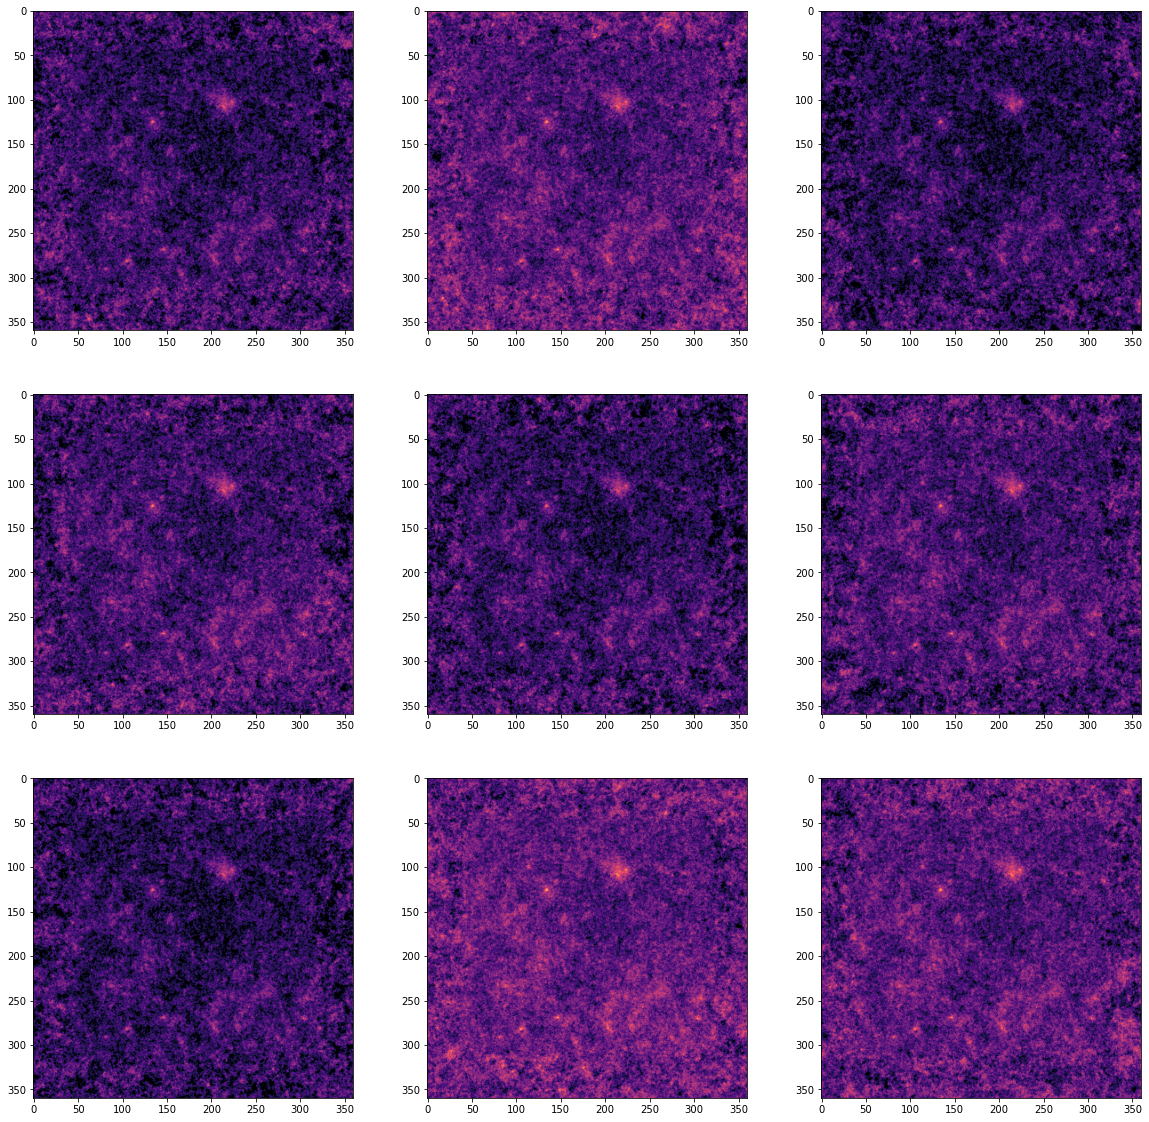

In [14]:
figure(figsize=[20,20])
kwargs=dict(cmap='magma', vmin=-0.05, vmax=0.2)
subplot(331)
imshow(samples[0,...], **kwargs)
subplot(332)
imshow(samples[1,...], **kwargs)
subplot(333)
imshow(samples[2,...], **kwargs)
subplot(334)
imshow(samples[3,...], **kwargs)
subplot(335)
imshow(samples[4,...], **kwargs)
subplot(336)
imshow(samples[5,...], **kwargs)
subplot(337)
imshow(samples[6,...], **kwargs)
subplot(338)
imshow(samples[7,...], **kwargs)
subplot(339)
imshow(samples[8,...], **kwargs)

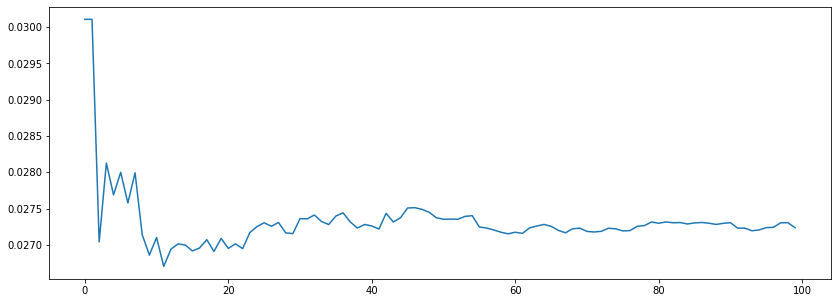

In [15]:
def rmse(a, b, mask):
    return(np.sqrt(np.sum(mask*(a-b)*(a-b))/np.sum(mask)))

l = [rmse(convergence, samples[0,...].reshape(360,360), mask[...,0])]
for i in range(1,samples.shape[0]):
    l.append(rmse(convergence, samples[:i,...].mean(0).reshape(360,360), mask[...,0]))
    
plot(l)

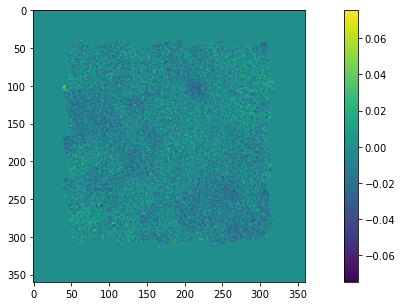

In [16]:
wf_e = np.load('res/wf_e.npy')
#samples = jnp.concatenate([samples, jnp.load('res/wiener_ode/wiener_samples1.npy')])
#samples = jnp.concatenate([samples, jnp.load('res/wiener_ode/wiener_samples2.npy')])
imshow(mask[...,0]*(samples[0,...]-wf_e))
colorbar()

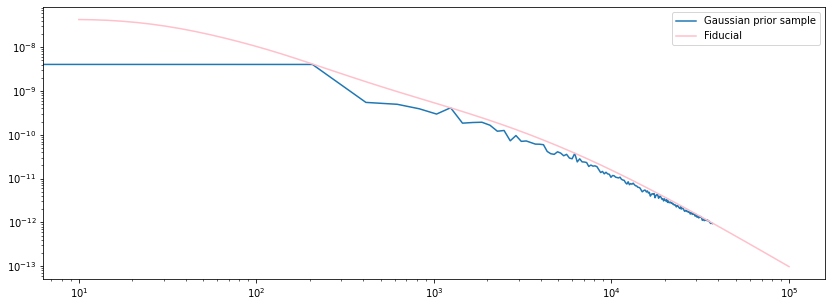

In [19]:
from jax_lensing import spectral
resolution = 0.29 # arcmin/pixel
pixel_size = np.pi * resolution / 180. / 60. #rad/pixel

gaussian_path = "../../data/ktng/ktng_PS_theory.npy"
ps_data_th = np.load(gaussian_path).astype('float32')
k_wiener, ps_wiener = spectral.measure_power_spectrum(samples[0,...], pixel_size)
loglog(k_wiener, ps_wiener, label='Gaussian prior sample')
gaussian_path = "../../data/ktng/ktng_PS_theory.npy"
ps_data_th = np.load(gaussian_path).astype('float32')
loglog(ps_data_th[0,:], ps_data_th[1,:], color='pink', label='Fiducial')
#loglog(ell[-1,...], ps[-1,...])
loglog()
legend()